# **Part I. Project Overview and Methodology**

## **1. Project Context**
This project uses raw customer-level subscription data from a Netflix-like streaming service, containing user demographics, subscription status, and engagement-related features. The dataset captures whether each user has churned or retained their subscription, along with behavioral signals such as usage intensity and account characteristics, enabling analysis of factors associated with customer churn and the development of predictive classification models.

## **2. Dataset Overview**



*   **Number of observations:** 5,000 users
*   **Number of features:** 14 columns
*   **Unit of analysis:** Individual customer (user-level subscription data)
*   **Target variable:** churned (binary indicator of subscription cancellation)

## **3. Variable Description**



*   `customer_id`: Unique identifier for each customer
*   `age`: Age of the customer
*   `gender`: Customer gender
*   `region`: Geographic region of the customer
*   `device`: Primary device used to access the platform
*   `subscription_type`: Type of subscription plan (e.g., Basic, Standard, Premium)
*   `monthly_fee`: Monthly subscription fee paid by the customer
*   `payment_method`: Payment method used for subscription billing
*   `number_of_profiles`: Number of profiles associated with the account
*   `watch_hours`: Total accumulated watch time on the platform
*   `avg_watch_time_per_day`: Average daily watch time per user
*   `last_login_days`: Number of days since the user last logged in
*   `favorite_genre`: Most frequently watched content genre
*   `churned`: Binary churn indicator (1 = churned, 0 = retained)

## **4. Project Goals**

*   Primary Goal: The primary goal of this project is to predict customer churn by leveraging user-level subscription and engagement data through supervised machine learning classification models.
*   Secondary Goal: The project also aims to identify which user characteristics and behavioral variables most strongly influence churn, and to understand their relative importance in predicting customer retention outcomes.

## **5. Methodology**

To address the project goals, this study applied a supervised machine learning classification framework to predict customer churn. Logistic Regression was first established as a baseline model, providing an interpretable reference point. Building on this baseline, several advanced classification models—including Decision Tree, Random Forest, Neural Network (MLP), and XGBoost—were trained and evaluated.

All models were evaluated consistently to enable fair comparison. Model performance was primarily evaluated using classification accuracy, allowing direct comparison of predictive effectiveness across different modeling approaches.

## **6. Summary of Results**

Among the evaluated models, XGBoost demonstrated the strongest predictive performance, achieving an accuracy of approximately 0.995. Feature-level analysis indicated that user engagement–related variables, such as watch time and recent activity, played a central role in distinguishing churned users from retained users.

Overall, the results support the project goal of accurate churn prediction and suggest that behavioral engagement signals are critical drivers in modeling customer retention using machine learning approaches.

## **7. Strategic Implications and Actionable Insights**

The results suggest that reducing churn depends less on static demographic attributes and more on sustaining consistent viewing behavior over time.

Based on this insight, effective retention strategies should focus on maintaining and increasing engagement levels, particularly among users exhibiting early signs of declining activity. Actionable approaches include personalized content recommendations, timely in-app notifications or email reminders, and reminder messaging tied to unfinished or similar content. Furthermore, systematically testing different recommendation and messaging strategies through A/B experimentation can help optimize engagement-driven interventions and support churn reduction efforts.

# **Part II. Data Preparation and Modeling**

## **1. Import & Setup**

In [1]:
import os
os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import ttest_ind

from IPython.display import display

from tableone import TableOne

In [5]:
file_path = '/content/drive/MyDrive/Data_Portfolio_Dataset/netflix_customer_churn.csv'
df = pd.read_csv(file_path)
df.head()

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


## **2. Data Exploration & Feature Preparation for Classification**

In [6]:
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int6

In [7]:
target_col = 'churned'                 # target variable
id_cols = ['customer_id']              # identifier columns
numeric_as_categorical = ['number_of_profiles', 'monthly_fee']  # numeric features treated as categorical

# extract raw numeric and categorical columns from the dataframe
numerical_cols_raw = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_raw = df.select_dtypes(include=['object', 'category']).columns.tolist()

# final numeric columns excluding target and numeric-as-categorical features
numerical_cols = [
    col for col in numerical_cols_raw
    if col not in [target_col] + numeric_as_categorical
]

# start with original categorical columns
categorical_cols = categorical_cols_raw.copy()
for col in numeric_as_categorical:
    if col not in categorical_cols:
        categorical_cols.append(col)

# remove identifier columns from categorical features
for col in id_cols:
    if col in categorical_cols:
        categorical_cols.remove(col)

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
print("Target column:", target_col)

Numerical columns: ['age', 'watch_hours', 'last_login_days', 'avg_watch_time_per_day']
Categorical columns: ['gender', 'subscription_type', 'region', 'device', 'payment_method', 'favorite_genre', 'number_of_profiles', 'monthly_fee']
Target column: churned


In [8]:
# check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

Missing values in each column:
customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

Number of duplicate rows: 0


In [9]:
unique_values = df.nunique()
print("Number of unique values in each column:")
print(unique_values)

Number of unique values in each column:
customer_id               5000
age                         53
gender                       3
subscription_type            3
watch_hours               2343
last_login_days             61
region                       6
device                       5
monthly_fee                  3
churned                      2
payment_method               5
number_of_profiles           5
avg_watch_time_per_day     505
favorite_genre               7
dtype: int64


In [10]:
# column setup
columns = numerical_cols + categorical_cols
categorical = categorical_cols

# TableOne by churn group with p-values
t1 = TableOne(
    data=df,
    columns=columns,
    categorical=categorical,
    groupby=target_col,
    pval=True,
)

# TableOne dataframe
t1_df = t1.tableone.copy()

# rename group columns
rename_map = {
    0: "Churn 0",
    1: "Churn 1",
    "0": "Churn 0",
    "1": "Churn 1",
    target_col: "Group",
    "Overall": "Overall",
    "P-Value": "p-value",
    "p": "p-value",
}
t1_df = t1_df.rename(columns={k: v for k, v in rename_map.items() if k in t1_df.columns})

# format p-values
if "p-value" in t1_df.columns:
    t1_df["p-value"] = t1_df["p-value"].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "NA")

# split numerical vs categorical
idx0 = t1_df.index.get_level_values(0) if hasattr(t1_df.index, "levels") else t1_df.index

numerical_table = t1_df[idx0.isin(numerical_cols)].copy()
categorical_table = t1_df[idx0.isin(categorical_cols)].copy()

print("\nNumerical summary table (TableOne)")
display(numerical_table)

print("\nCategorical summary table (TableOne)")
display(categorical_table)


Numerical summary table (TableOne)


Empty DataFrame
Columns: [(Grouped by churned, Missing), (Grouped by churned, Overall), (Grouped by churned, 0), (Grouped by churned, 1), (Grouped by churned, P-Value)]
Index: []


Categorical summary table (TableOne)


Empty DataFrame
Columns: [(Grouped by churned, Missing), (Grouped by churned, Overall), (Grouped by churned, 0), (Grouped by churned, 1), (Grouped by churned, P-Value)]
Index: []

|                                   |               | Missing   | Overall     | 0           | 1           | P-Value   |
|-----------------------------------|---------------|-----------|-------------|-------------|-------------|-----------|
| n                                 |               |           | 5000        | 2485        | 2515        |           |
| age, mean (SD)                    |               | 0         | 43.8 (15.5) | 43.9 (15.5) | 43.8 (15.5) | 0.804     |
| watch_hours, mean (SD)            |               | 0         | 11.6 (12.0) | 17.4 (13.9) | 5.9 (5.4)   | <0.001    |
| last_login_days, mean (SD)        |               | 0         | 30.1 (17.5) | 21.8 (16.2) | 38.3 (14.8) | <0.001    |
| avg_watch_time_per_day, mean (SD) |               | 0         | 0.9 (2.6)   | 1.6 (3.6)   | 0.2 (0.2)   | <0.001    |
| gender, n (%)                     | Female        |           | 1711 (34.2) | 837 (33.7)  | 874 (34.8)  | 0.722     |
|                                   | Male          |           | 1654 (33.1) | 827 (33.3)  | 827 (32.9)  |           |
|                                   | Other         |           | 1635 (32.7) | 821 (33.0)  | 814 (32.4)  |           |
| subscription_type, n (%)          | Basic         |           | 1661 (33.2) | 634 (25.5)  | 1027 (40.8) | <0.001    |
|                                   | Premium       |           | 1693 (33.9) | 953 (38.4)  | 740 (29.4)  |           |
|                                   | Standard      |           | 1646 (32.9) | 898 (36.1)  | 748 (29.7)  |           |
| region, n (%)                     | Africa        |           | 803 (16.1)  | 415 (16.7)  | 388 (15.4)  | 0.753     |
|                                   | Asia          |           | 841 (16.8)  | 415 (16.7)  | 426 (16.9)  |           |
|                                   | Europe        |           | 867 (17.3)  | 419 (16.9)  | 448 (17.8)  |           |
|                                   | North America |           | 851 (17.0)  | 430 (17.3)  | 421 (16.7)  |           |
|                                   | Oceania       |           | 765 (15.3)  | 382 (15.4)  | 383 (15.2)  |           |
|                                   | South America |           | 873 (17.5)  | 424 (17.1)  | 449 (17.9)  |           |
| device, n (%)                     | Desktop       |           | 949 (19.0)  | 482 (19.4)  | 467 (18.6)  | 0.836     |
|                                   | Laptop        |           | 1006 (20.1) | 485 (19.5)  | 521 (20.7)  |           |
|                                   | Mobile        |           | 1004 (20.1) | 497 (20.0)  | 507 (20.2)  |           |
|                                   | TV            |           | 993 (19.9)  | 497 (20.0)  | 496 (19.7)  |           |
|                                   | Tablet        |           | 1048 (21.0) | 524 (21.1)  | 524 (20.8)  |           |
| payment_method, n (%)             | Credit Card   |           | 973 (19.5)  | 549 (22.1)  | 424 (16.9)  | <0.001    |
|                                   | Crypto        |           | 995 (19.9)  | 401 (16.1)  | 594 (23.6)  |           |
|                                   | Debit Card    |           | 1030 (20.6) | 580 (23.3)  | 450 (17.9)  |           |
|                                   | Gift Card     |           | 976 (19.5)  | 412 (16.6)  | 564 (22.4)  |           |
|                                   | PayPal        |           | 1026 (20.5) | 543 (21.9)  | 483 (19.2)  |           |
| favorite_genre, n (%)             | Action        |           | 697 (13.9)  | 332 (13.4)  | 365 (14.5)  | 0.324     |
|                                   | Comedy        |           | 685 (13.7)  | 343 (13.8)  | 342 (13.6)  |           |
|                                   | Documentary   |           | 729 (14.6)  | 359 (14.4)  | 370 (14.7)  |           |
|                                   | Drama         |           | 731 (14.6)  | 349 (14.0)  | 382 (15.2)  |           |
|                                   | Horror        |           | 713 (14.3)  | 346 (13.9)  | 367 (14.6)  |           |
|                                   | Romance       |           | 725 (14.5)  | 375 (15.1)  | 350 (13.9)  |           |
|                                   | Sci-Fi        |           | 720 (14.4)  | 381 (15.3)  | 339 (13.5)  |           |
| number_of_profiles, n (%)         | 1             |           | 972 (19.4)  | 402 (16.2)  | 570 (22.7)  | <0.001    |
|                                   | 2             |           | 1001 (20.0) | 426 (17.1)  | 575 (22.9)  |           |
|                                   | 3             |           | 994 (19.9)  | 419 (16.9)  | 575 (22.9)  |           |
|                                   | 4             |           | 999 (20.0)  | 624 (25.1)  | 375 (14.9)  |           |
|                                   | 5             |           | 1034 (20.7) | 614 (24.7)  | 420 (16.7)  |           |
| monthly_fee, n (%)                | 13.99         |           | 1646 (32.9) | 898 (36.1)  | 748 (29.7)  | <0.001    |
|                                   | 17.99         |           | 1693 (33.9) | 953 (38.4)  | 740 (29.4)  |           |
|                                   | 8.99          |           | 1661 (33.2) | 634 (25.5)  | 1027 (40.8) |           |

#### **1) Overall Insights**
*   The dataset consists of 5,000 users with a balanced churn distribution, enabling reliable group comparisons.
*   Churn is primarily associated with user engagement and subscription-related behaviors, rather than demographic characteristics.
*   Behavioral signals such as viewing intensity and recency of activity exhibit the strongest statistical relationship with churn.
*   Demographic and preference-based variables show limited discriminatory power, suggesting that churn is driven by how users engage with the service, not who they are.

#### **2) Numerical Feature Insights**

**Age**
*   The average age is nearly identical between churned and non-churned users, with no statistically significant difference.
*   This indicates that age alone does not meaningfully influence churn behavior.

**Total Watch Hours**
*   Churned users exhibit substantially lower total watch hours compared to non-churned users.
*   This highlights overall consumption volume as a key indicator of churn risk.

**Average Watch Time per Day**
*   Daily viewing intensity is markedly lower among churned users.
*   A decline in average daily engagement appears to be a strong early signal of churn.

**Last Login Days**
*   Churned users have significantly longer gaps since their last login.
*   Reduced recency of activity strongly correlates with higher churn likelihood.

#### **3) Categorical Feature Insights**

**Gender**
*   Churn rates are consistent across gender categories, with no statistically significant differences observed.
*   Gender does not appear to be a meaningful driver of churn.

**Subscription Type**
*   Users on lower-tier subscription plans show higher churn rates, while premium subscribers are more likely to retain.
*   Subscription tier reflects differences in user commitment and perceived value.

**Region**
*   Churn rates are broadly similar across regions, suggesting limited geographic effects on churn behavior.

**Device Type**
*   No significant churn differences are observed across device categories.
*   Device usage patterns do not substantially influence churn outcomes.

**Payment Method**
*   Churn rates vary significantly by payment method.
*   More stable payment options (e.g., credit card, PayPal) are associated with lower churn, while alternative methods show higher churn rates.

**Favorite Genre**
*   Content genre preferences show no statistically significant relationship with churn.
*   Content taste alone does not explain churn behavior.

**Number of Profiles**
*   Accounts with fewer profiles exhibit higher churn rates.
*   Multi-profile usage suggests shared or family accounts with stronger service dependency and lower churn risk.

## **3. Exploratory Data Analysis (EDA)**

## **3.1 Target Feature Distribution**

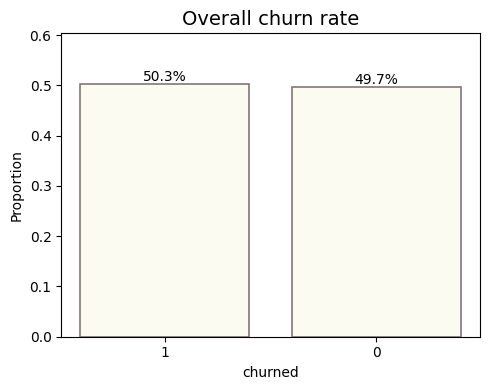

In [11]:
def plot_overall_churn_rate(
    df,
    target_col,
    fill_color="#FBFBF2",
    line_color="#847577"
):
    # plot overall churn vs non-churn rate
    counts = df[target_col].value_counts(dropna=False)
    proportions = counts / len(df)

    categories = [str(x) for x in counts.index]

    plt.figure(figsize=(5, 4))

    bars = plt.bar(
        categories,
        proportions.values,
        color=fill_color,
        edgecolor=line_color,
        linewidth=1.2
    )

    max_height = proportions.values.max()
    plt.ylim(0, max_height * 1.2)

    for bar, prop in zip(bars, proportions.values):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{prop * 100:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10
        )

    plt.title("Overall churn rate", fontsize=14)
    plt.xlabel(target_col)
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()


# function call
plot_overall_churn_rate(df, target_col)

*   The proportions of churned and non-churned users are nearly equal, with churned users showing a slight predominance.


## **3.2 Categorical Features Distribution**

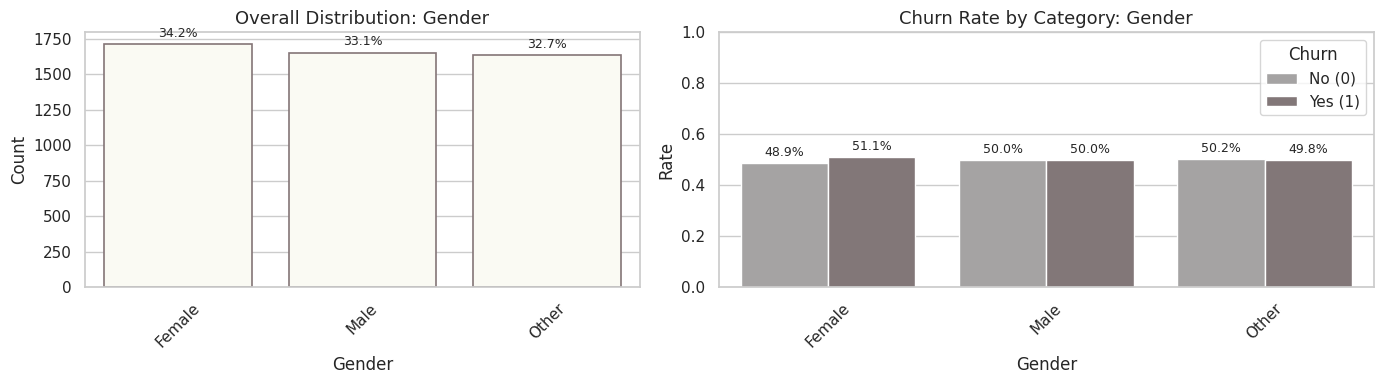

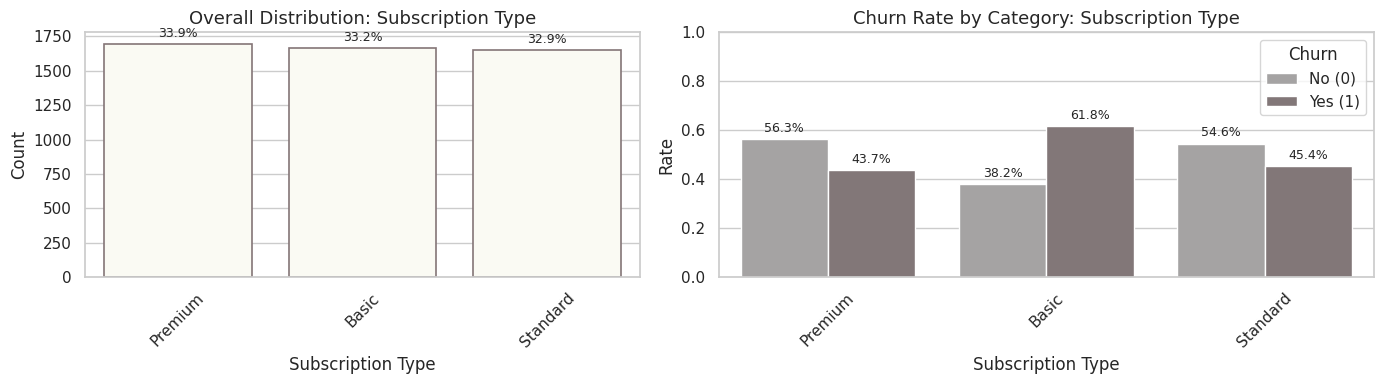

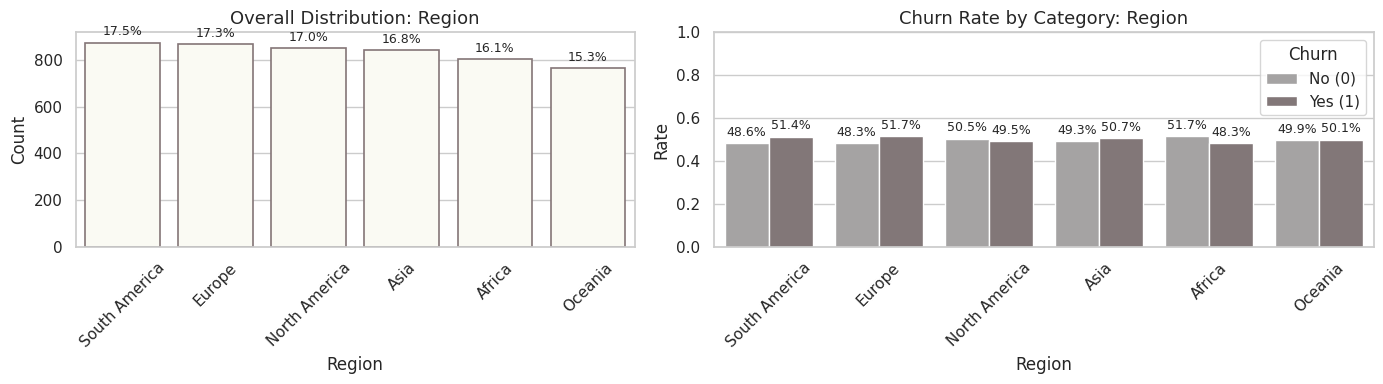

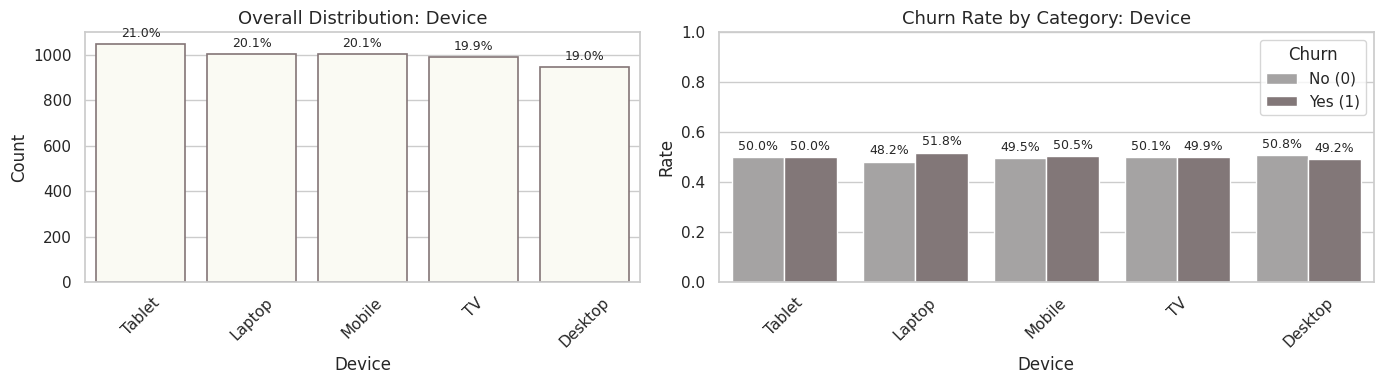

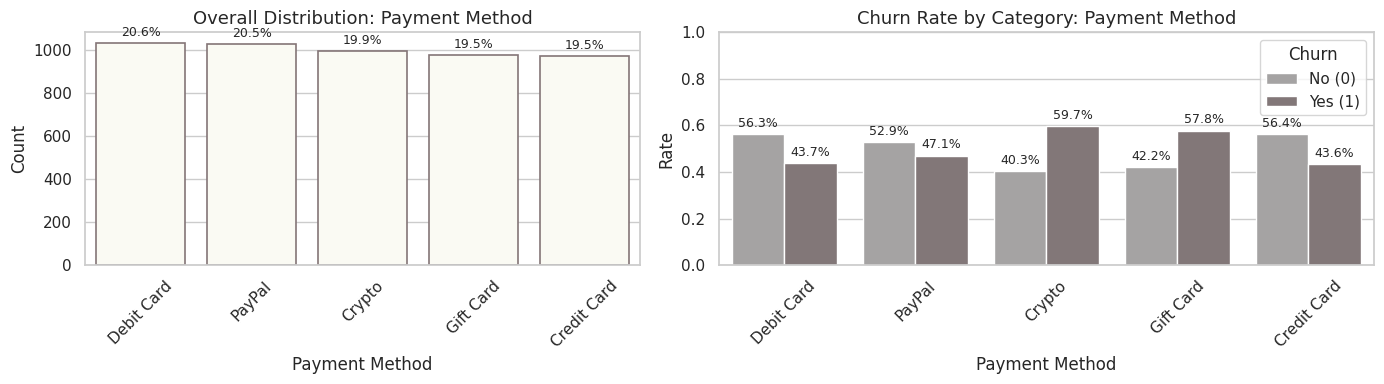

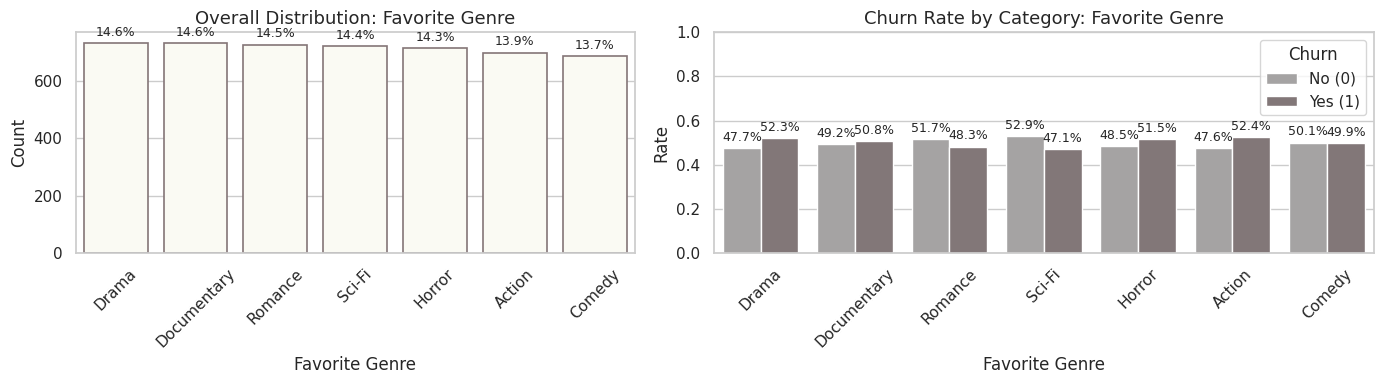

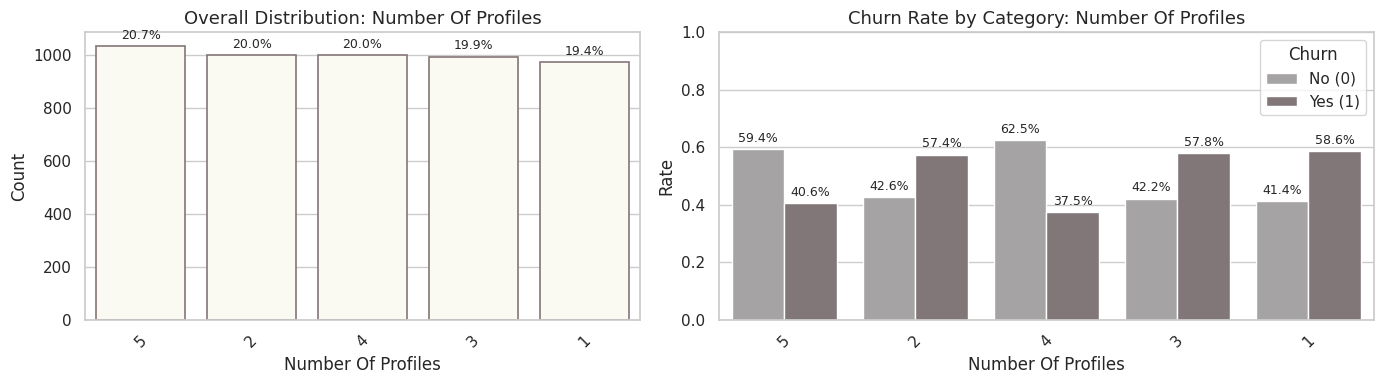

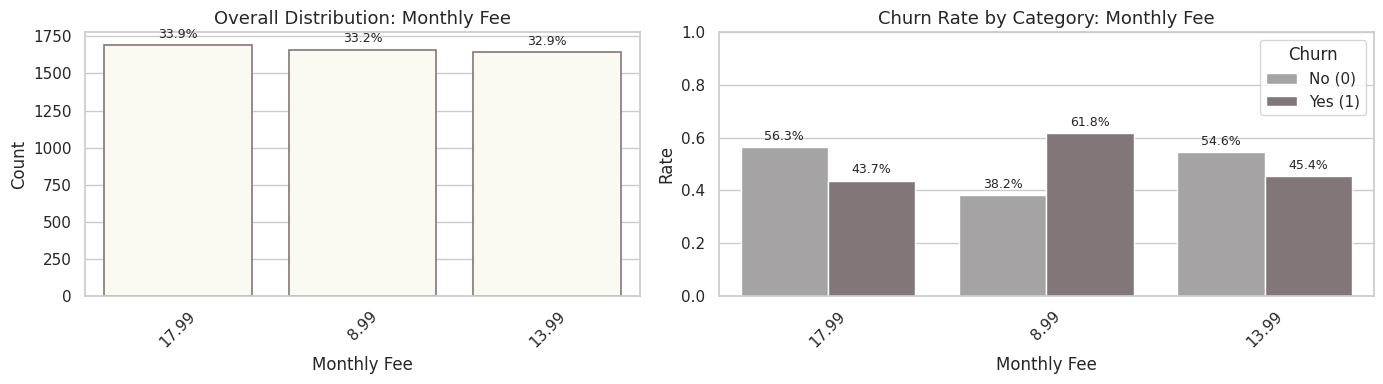

In [34]:
# palette
PALETTE = ['#FBFBF2', '#E5E6E4', '#CFD2CD', '#A6A2A2', '#847577']

# plot colors
FILL_COLOR = '#FBFBF2'
EDGE_COLOR = '#847577'
CHURN_NO = '#A6A2A2'
CHURN_YES = '#847577'

sns.set(style="whitegrid")

def prettify_title(col_name):
    # snake_case to title case
    return col_name.replace("_", " ").title()

def plot_categorical_overall_and_churnrate(df, categorical_cols, target_col, max_categories=15):
    # overall distribution and churn rate by category
    for col in categorical_cols:
        tmp = df[[col, target_col]].copy()
        tmp = tmp.dropna(subset=[col, target_col])
        tmp[col] = tmp[col].astype(str)

        # category cap
        vc = tmp[col].value_counts()
        if len(vc) > max_categories:
            top_cats = vc.head(max_categories).index
            tmp[col] = tmp[col].where(tmp[col].isin(top_cats), other="Other")

        order = tmp[col].value_counts().index.tolist()
        total_n = len(tmp)

        # churn rate table
        rate_df = pd.crosstab(tmp[col], tmp[target_col], normalize='index')
        if 0 not in rate_df.columns:
            rate_df[0] = 0.0
        if 1 not in rate_df.columns:
            rate_df[1] = 0.0
        rate_df = rate_df[[0, 1]].reset_index().rename(columns={col: "category", 0: "churn_0", 1: "churn_1"})

        # long format
        rate_long = pd.melt(
            rate_df,
            id_vars=["category"],
            value_vars=["churn_0", "churn_1"],
            var_name="churn",
            value_name="rate"
        )
        rate_long["churn"] = rate_long["churn"].map({"churn_0": "No (0)", "churn_1": "Yes (1)"})

        # subplot layout
        fig, axes = plt.subplots(
            1, 2, figsize=(14, 4),
            gridspec_kw={"width_ratios": [1.1, 1.3]}
        )

        # overall distribution
        ax0 = sns.countplot(
            data=tmp,
            x=col,
            order=order,
            color=FILL_COLOR,
            edgecolor=EDGE_COLOR,
            linewidth=1.2,
            ax=axes[0]
        )

        axes[0].set_title(
            f"Overall Distribution: {prettify_title(col)}",
            fontsize=13
        )
        axes[0].set_xlabel(prettify_title(col))
        axes[0].set_ylabel("Count")
        axes[0].tick_params(axis='x', rotation=45)

        # overall percent labels
        for p in ax0.patches:
            count = p.get_height()
            pct = count / total_n * 100
            ax0.annotate(
                f"{pct:.1f}%",
                (p.get_x() + p.get_width() / 2, count),
                ha="center",
                va="bottom",
                fontsize=9,
                xytext=(0, 3),
                textcoords="offset points"
            )

        # churn rate bars
        ax1 = sns.barplot(
            data=rate_long,
            x="category",
            y="rate",
            hue="churn",
            order=order,
            palette={"No (0)": CHURN_NO, "Yes (1)": CHURN_YES},
            ax=axes[1]
        )

        axes[1].set_title(
            f"Churn Rate by Category: {prettify_title(col)}",
            fontsize=13
        )
        axes[1].set_xlabel(prettify_title(col))
        axes[1].set_ylabel("Rate")
        axes[1].set_ylim(0, 1)
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend(title="Churn")

        # churn rate percent labels
        for p in ax1.patches:
            height = p.get_height()
            if height > 0:
                ax1.annotate(
                    f"{height * 100:.1f}%",
                    (p.get_x() + p.get_width() / 2, height),
                    ha="center",
                    va="bottom",
                    fontsize=9,
                    xytext=(0, 3),
                    textcoords="offset points"
                )

        plt.tight_layout()
        plt.show()

# function call
plot_categorical_overall_and_churnrate(df, categorical_cols, target_col, max_categories=15)

#### **Categorical Feature Insights (Churn vs. Non-Churn)**

**Gender**
*   No noticeable differences are observed in churn rates among the 3 genders.

**Subscription Type**
*   A substantial difference is observed across subscription tiers.
*   The Basic plan, which is the least expensive, exhibits the highest churn rate, while churn decreases as the subscription fee increases.
*   *(Refer to the visualization below.)* Interestingly, Premium users show a higher proportion of accounts with 4–5 profiles, whereas Basic users show a higher proportion with 1–2 profiles.
*   This suggests that a lower cost burden per user in multi-profile accounts may contribute to their lower churn rate.

 **Region**
*   Europe records the highest churn rate; however, regional differences overall are minimal, making it difficult to derive significant insights.

**Device**
*   Users who watch on laptops show the highest churn rate.
While the differences are not highly significant, the viewing environment appears to exert a subtle influence on churn behavior.

**Payment Method**
*   Churn rates vary substantially by payment method. Users paying with crypto or gift cards exhibit largely higher churn rate compared to other methods.
*   Given that gift cards inherently encourage one-time usage and crypto payments are highly volatile, more stable payment methods tend to be associated with higher retention.
*   This indicates the need for retention strategies targeting one-time users, such as offering renewal incentives.

**Favorite Genre**
*   No noticeable differences in churn rates are observed across genre preferences.

**Number of Profiles**
*    Churn varies sharply by profile count and appears to be a highly influential predictor.
*   Users with 1–3 profiles churn at significantly higher rates than those with 4–5 profiles.
*   Accounts with the maximum of 5 profiles demonstrate particularly strong retention.
*   As with subscription type, reduced per-person cost burden within multi-profile households likely plays a meaningful role in sustaining subscriptions.

****Reference***

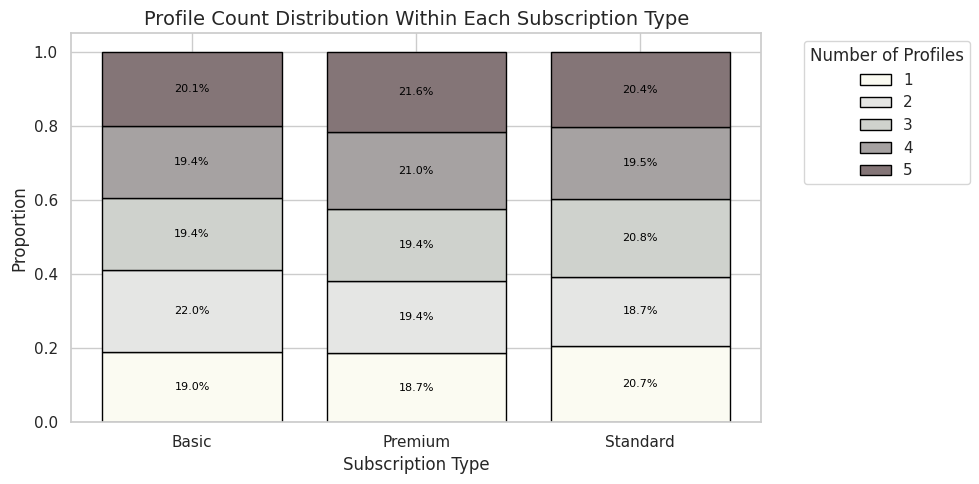

In [13]:
sns.set(style="whitegrid")

# stack colors
stack_colors = ['#FBFBF2', '#E5E6E4', '#CFD2CD', '#A6A2A2', '#847577']

def plot_subscription_profile_ratio(df, sub_col, profile_col):
    # profile ratio by subscription

    # normalized crosstab
    ct = pd.crosstab(df[sub_col], df[profile_col], normalize='index')

    # raw counts
    ct_counts = pd.crosstab(df[sub_col], df[profile_col])

    plt.figure(figsize=(10, 5))

    # stacked bars
    bars = plt.bar(
        ct.index,
        ct.iloc[:, 0],
        color=stack_colors[0],
        edgecolor='black'
    )

    for i in range(1, ct.shape[1]):
        plt.bar(
            ct.index,
            ct.iloc[:, i],
            bottom=ct.iloc[:, :i].sum(axis=1),
            color=stack_colors[i],
            edgecolor='black'
        )

    # percent labels
    for i, sub in enumerate(ct.index):
        cumulative = 0
        for j, prof in enumerate(ct.columns):
            value = ct.iloc[i, j]
            if value > 0:
                # label position
                y_pos = cumulative + value / 2
                plt.text(
                    i, y_pos,
                    f"{value * 100:.1f}%",
                    ha='center',
                    va='center',
                    fontsize=8,
                    color='black'
                )
            cumulative += value

    plt.title("Profile Count Distribution Within Each Subscription Type", fontsize=14)
    plt.xlabel("Subscription Type")
    plt.ylabel("Proportion")
    plt.xticks(rotation=0)
    plt.legend(
        title="Number of Profiles",
        labels=ct.columns.astype(str),
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    plt.tight_layout()
    plt.show()


# function call
plot_subscription_profile_ratio(df, 'subscription_type', 'number_of_profiles')

## **3.2 Numerical Features Distribution**

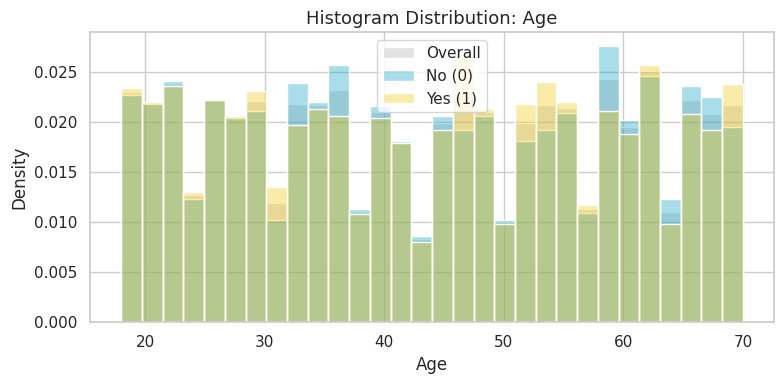

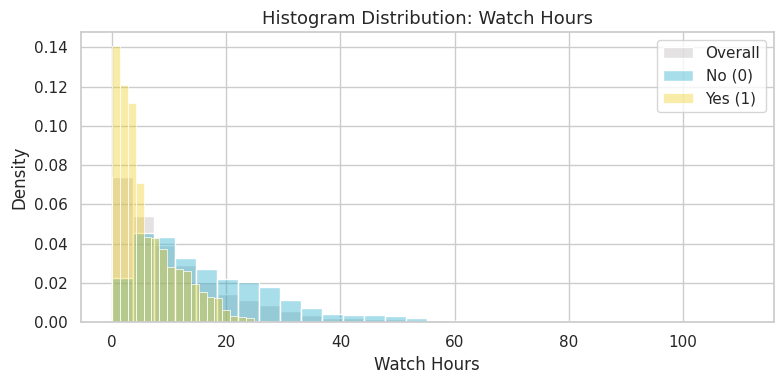

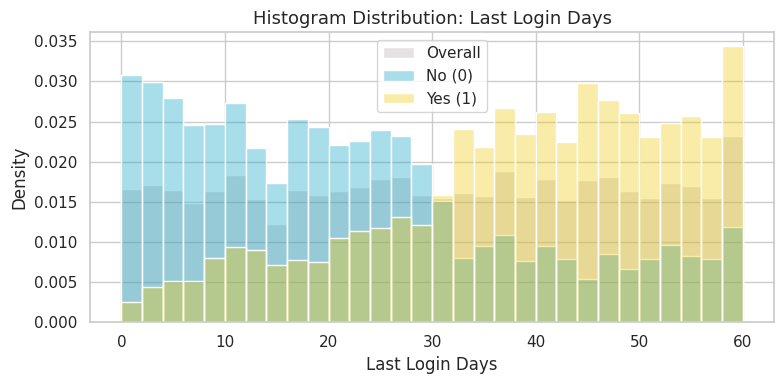

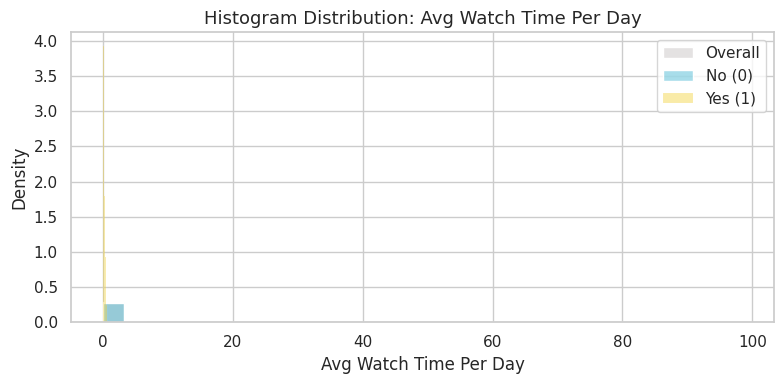

In [14]:
sns.set(style="whitegrid")

# histogram colors
COLOR_OVERALL = "#A6A2A2"
COLOR_NO = "#07A0C3"
COLOR_YES = "#F0C808"

def plot_numerical_hist_overall_yes_no(df, numerical_cols, target_col, bins=30):
    # numerical distribution by churn

    for col in numerical_cols:
        tmp = df[[col, target_col]].copy()
        tmp = tmp.dropna(subset=[col, target_col])

        # numeric casting
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
        tmp = tmp.dropna(subset=[col])

        # skip low variation
        if tmp.empty or tmp[col].nunique() < 2:
            print(f"Skip {col}: insufficient numeric variation.")
            continue

        data_all = tmp[col]
        data_no = tmp.loc[tmp[target_col] == 0, col]
        data_yes = tmp.loc[tmp[target_col] == 1, col]

        plt.figure(figsize=(8, 4))

        # overall distribution
        sns.histplot(
            data_all,
            bins=bins,
            stat="density",
            color=COLOR_OVERALL,
            alpha=0.30,
            label="Overall"
        )

        # churn 0
        if data_no.nunique() >= 2:
            sns.histplot(
                data_no,
                bins=bins,
                stat="density",
                color=COLOR_NO,
                alpha=0.35,
                label="No (0)"
            )

        # churn 1
        if data_yes.nunique() >= 2:
            sns.histplot(
                data_yes,
                bins=bins,
                stat="density",
                color=COLOR_YES,
                alpha=0.35,
                label="Yes (1)"
            )

        plt.title(f"Histogram Distribution: {col.replace('_', ' ').title()}", fontsize=13)
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()


# function call
plot_numerical_hist_overall_yes_no(df, numerical_cols, target_col)

IQR bounds: [-0.805, 1.635] | Removed: 549 / 5000 (11.0%)


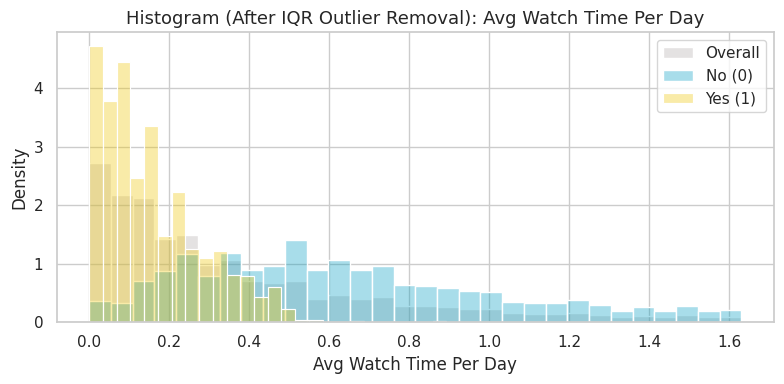

In [15]:
sns.set(style="whitegrid")

# histogram colors
COLOR_OVERALL = "#A6A2A2"
COLOR_NO = "#07A0C3"
COLOR_YES = "#F0C808"

def remove_outliers_iqr(df, col, k=1.5):
    # iqr bounds
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

def plot_avg_watch_time_hist_after_iqr(
    df,
    col="avg_watch_time_per_day",
    target_col="churn",
    bins=30,
    k=1.5
):
    tmp = df[[col, target_col]].copy()
    tmp = tmp.dropna(subset=[col, target_col])

    # numeric casting
    tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    tmp = tmp.dropna(subset=[col])

    # iqr bounds
    lower, upper = remove_outliers_iqr(tmp, col, k=k)

    # outlier filter
    tmp_filtered = tmp[(tmp[col] >= lower) & (tmp[col] <= upper)].copy()

    # removal summary
    removed = len(tmp) - len(tmp_filtered)
    print(
        f"IQR bounds: [{lower:.3f}, {upper:.3f}] | "
        f"Removed: {removed} / {len(tmp)} ({removed/len(tmp)*100:.1f}%)"
    )

    data_all = tmp_filtered[col]
    data_no = tmp_filtered.loc[tmp_filtered[target_col] == 0, col]
    data_yes = tmp_filtered.loc[tmp_filtered[target_col] == 1, col]

    plt.figure(figsize=(8, 4))

    # overall distribution
    sns.histplot(
        data_all,
        bins=bins,
        stat="density",
        color=COLOR_OVERALL,
        alpha=0.30,
        label="Overall"
    )

    # churn 0
    if data_no.nunique() >= 2:
        sns.histplot(
            data_no,
            bins=bins,
            stat="density",
            color=COLOR_NO,
            alpha=0.35,
            label="No (0)"
        )

    # churn 1
    if data_yes.nunique() >= 2:
        sns.histplot(
            data_yes,
            bins=bins,
            stat="density",
            color=COLOR_YES,
            alpha=0.35,
            label="Yes (1)"
        )

    plt.title(
        f"Histogram (After IQR Outlier Removal): {col.replace('_', ' ').title()}",
        fontsize=13
    )
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


# function call
plot_avg_watch_time_hist_after_iqr(
    df,
    col="avg_watch_time_per_day",
    target_col=target_col,
    bins=30,
    k=1.5
)

#### **Numerical Feature Insights (Churn vs. Non-Churn)**
**Age**
*   No clear linear relationship between age and churn likelihood can be identified.

**Watch Hours**
*   There is a significant difference between the two groups.
*   Churned users record largely fewer watch hours, resulting in a distribution that is heavily left-skewed compared to non-churned users.

**Last Login Days**:
*   A stark contrast is observed between churned and non-churned users.
Non-churned users tend to return to the service relatively quickly, while churned users exhibit long periods of inactivity.
*   As the number of days since last login increases, the probability of churn correspondingly rises.

**Avg Watch Time Per Day**:
*   A significant difference exists between the two groups.
Similar to total watch hours, churned users show extremely concentrated usage at the lowest end of the distribution.
*   As daily watch time increases, the churn rate tends to decline.
*   The churn–engagement relationship remains robust after applying IQR-based outlier removal, confirming that lower average daily watch time is systematically associated with higher churn risk.

## **4. Feature Engineering & Statistical Validation**

## **4.1 Skewed Feature Transformation**

In [16]:
# log transformation
df["watch_hours_log"] = np.log1p(df["watch_hours"])
df["avg_watch_time_per_day_log"] = np.log1p(df["avg_watch_time_per_day"])

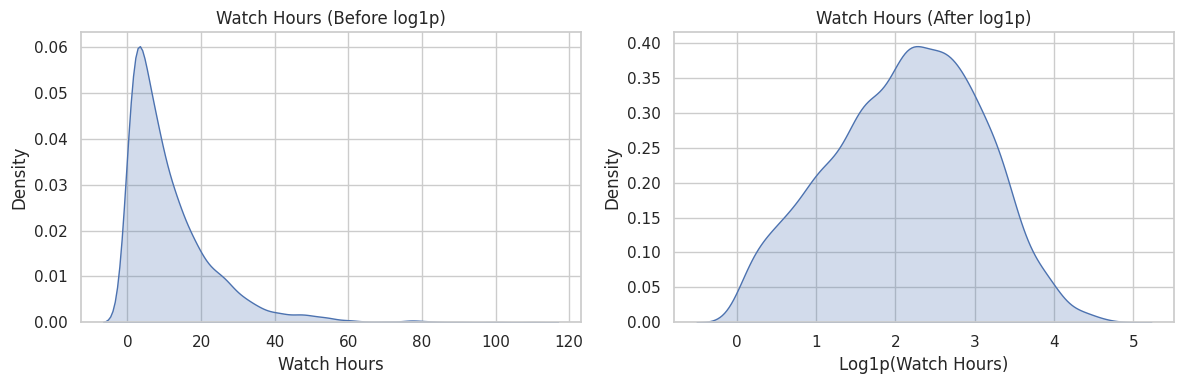

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# before transformation
sns.kdeplot(df["watch_hours"], ax=axes[0], fill=True)
axes[0].set_title("Watch Hours (Before log1p)")
axes[0].set_xlabel("Watch Hours")

# after transformation
sns.kdeplot(df["watch_hours_log"], ax=axes[1], fill=True)
axes[1].set_title("Watch Hours (After log1p)")
axes[1].set_xlabel("Log1p(Watch Hours)")

plt.tight_layout()
plt.show()

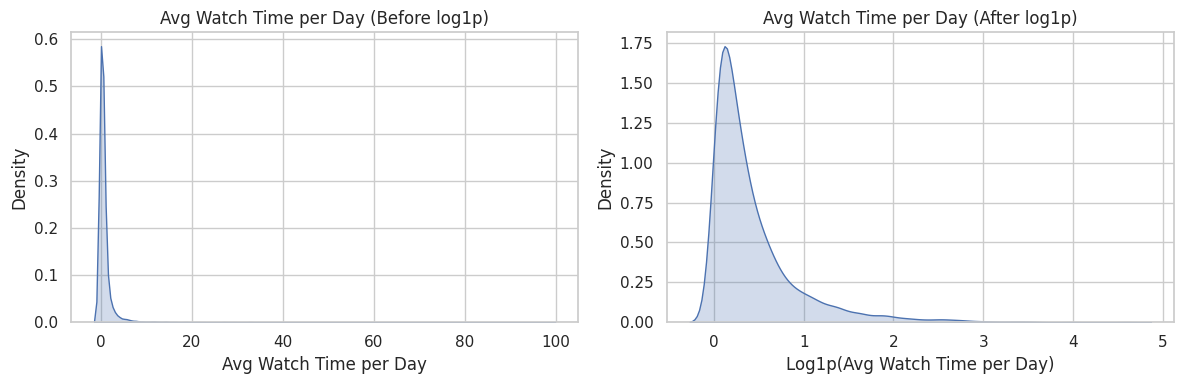

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# before transformation
sns.kdeplot(df["avg_watch_time_per_day"], ax=axes[0], fill=True)
axes[0].set_title("Avg Watch Time per Day (Before log1p)")
axes[0].set_xlabel("Avg Watch Time per Day")

# after transformation
sns.kdeplot(df["avg_watch_time_per_day_log"], ax=axes[1], fill=True)
axes[1].set_title("Avg Watch Time per Day (After log1p)")
axes[1].set_xlabel("Log1p(Avg Watch Time per Day)")

plt.tight_layout()
plt.show()



*   Both `watch_hours` and `avg_watch_time_per_day` exhibited strong right-skewness in their original distributions.
*   To mitigate the influence of extreme values and stabilize the distributions, a log1p transformation was applied.
*   After transformation, the distribution of `watch_hours_log` became noticeably more symmetric, with reduced skewness, making them more suitable for downstream modeling.

In [19]:
def ttest_by_churn(df, col, target_col="churn"):
    # two-sample t-test by churn
    g0 = df.loc[df[target_col] == 0, col].dropna()
    g1 = df.loc[df[target_col] == 1, col].dropna()

    if len(g0) > 1 and len(g1) > 1:
        stat, p = ttest_ind(g0, g1, equal_var=False)
        return p
    else:
        return np.nan

# compute p-values
p_avg_log = ttest_by_churn(df, "avg_watch_time_per_day_log", target_col)
p_watch_log = ttest_by_churn(df, "watch_hours_log", target_col)

# p-value table
pval_compare = pd.DataFrame({
    "variable": [
        "avg_watch_time_per_day_log",
        "watch_hours_log"
    ],
    "p_value": [
        p_avg_log,
        p_watch_log
    ]
})

# round p-values
pval_compare["p_value"] = pval_compare["p_value"].round(4)
pval_compare

,variable,p_value
0,avg_watch_time_per_day_log,0.0
1,watch_hours_log,0.0


*   Log transformation does not materially affect p-values; statistical significance is preserved, supporting the use of log-scaled features.
*   Therefore, Log transformation was applied to stabilize the distribution and reduce the influence of extreme values, without affecting statistical significance.

## **4.2 VIF Analysis**

In [20]:
def calculate_vif(df, features):
    # vif calculation
    X = df[features].copy()

    # standard scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # vif table
    vif_df = pd.DataFrame()
    vif_df["feature"] = features
    vif_df["VIF"] = [
        variance_inflation_factor(X_scaled, i)
        for i in range(X_scaled.shape[1])
    ]

    return vif_df

In [21]:
# vif feature list
vif_features = [
    "watch_hours_log",
    "avg_watch_time_per_day_log",
    "last_login_days",
    "monthly_fee",
    "number_of_profiles"
]

# compute vif
vif_result = calculate_vif(df, vif_features)
vif_result

# sort by vif
vif_result.sort_values("VIF", ascending=False).reset_index(drop=True)

# vif interpretation
vif_result["interpretation"] = vif_result["VIF"].apply(
    lambda x: "High multicollinearity" if x >= 5
    else "Moderate" if x >= 2
    else "Low"
)

vif_result

,feature,VIF,interpretation
0,watch_hours_log,1.905343,Low
1,avg_watch_time_per_day_log,2.785191,Moderate
2,last_login_days,1.886796,Low
3,monthly_fee,1.000797,Low
4,number_of_profiles,1.001085,Low




*   VIF analysis indicates no severe multicollinearity among the numeric predictors (all VIF < 3).
*   The moderately higher VIF of `avg_watch_time_per_day_log` suggests partial overlap with other engagement variables, most notably `watch_hours_log`, which is conceptually expected.

## **5. Baseline Model Setup & Train/Test Split**

In [22]:
# feature sets
numeric_A = ["watch_hours_log", "last_login_days", "monthly_fee", "number_of_profiles"]
numeric_B = numeric_A + ["avg_watch_time_per_day_log"]

categorical_features = ["subscription_type", "payment_method"]

features_A = numeric_A + categorical_features
features_B = numeric_B + categorical_features

X_A = df[features_A].copy()
X_B = df[features_B].copy()
y = df[target_col].copy()

# train test split
X_train_A, X_test_A, y_train, y_test = train_test_split(
    X_A, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# align feature sets
X_train_B = X_B.loc[X_train_A.index]
X_test_B  = X_B.loc[X_test_A.index]

print("Train A:", X_train_A.shape, "Test A:", X_test_A.shape)
print("Train churn rate:", round(float(y_train.mean()), 3), "Test churn rate:", round(float(y_test.mean()), 3))

Train A: (3500, 6) Test A: (1500, 6)
Train churn rate: 0.503 Test churn rate: 0.503


In [23]:
def make_preprocessor(numeric_features, categorical_features):
    # preprocessing pipeline
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ]
    )

def evaluate_model(model, X, y, threshold=0.5):
    # model evaluation metrics
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    return {
        "threshold": threshold,
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y, y_prob),
        "confusion_matrix": confusion_matrix(y, y_pred),
    }

## **6. Model Development**

## **6.1 Baseline Logistic Regression**

In [24]:
# baseline a
pre_A = make_preprocessor(numeric_A, categorical_features)

logreg_A = Pipeline(steps=[
    ("preprocessor", pre_A),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_A.fit(X_train_A, y_train)
res_A = evaluate_model(logreg_A, X_test_A, y_test, threshold=0.5)

# baseline b
pre_B = make_preprocessor(numeric_B, categorical_features)

logreg_B = Pipeline(steps=[
    ("preprocessor", pre_B),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

logreg_B.fit(X_train_B, y_train)
res_B = evaluate_model(logreg_B, X_test_B, y_test, threshold=0.5)

# baseline comparison table
baseline_compare = pd.DataFrame([
    {"model": "Baseline A (w/o avg_watch_time_per_day_log)", **{k: v for k, v in res_A.items() if k != "confusion_matrix"}},
    {"model": "Baseline B (with avg_watch_time_per_day_log)", **{k: v for k, v in res_B.items() if k != "confusion_matrix"}},
])

# metric rounding
for c in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    baseline_compare[c] = baseline_compare[c].round(3)

baseline_compare

,model,threshold,accuracy,precision,recall,f1,roc_auc
0,Baseline A (w/o avg_watch_time_per_day_log),0.5,0.897,0.892,0.906,0.899,0.967
1,Baseline B (with avg_watch_time_per_day_log),0.5,0.899,0.885,0.918,0.901,0.971


In [25]:
# final feature set
final_numeric_features = numeric_B
final_categorical_features = categorical_features
final_features = final_numeric_features + final_categorical_features

# final preprocessor
final_preprocessor = pre_B                # version with avg_watch_time
X_train_final = X_train_B
X_test_final  = X_test_B

# final baseline model
final_baseline_model = logreg_B           # selected baseline model
final_baseline_res   = res_B



*   Although `avg_watch_time_per_day_log` exhibited residual skewness, incorporating the feature into the baseline model resulted in improved recall and F1-score.

## **6.2 Decision Tree**

In [26]:
dt_model = Pipeline(steps=[
    ("preprocessor", final_preprocessor),
    ("classifier", DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=20,
        random_state=42
    ))
])

# model training
dt_model.fit(X_train_final, y_train)

# model evaluation
dt_res = evaluate_model(dt_model, X_test_final, y_test)

## **6.3 Random Forest**

In [27]:
rf_model = Pipeline(steps=[
    ("preprocessor", final_preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

# model training
rf_model.fit(X_train_final, y_train)

# model evaluation
rf_res = evaluate_model(rf_model, X_test_final, y_test)

## **6.4 Neural Network (MLP)**

In [28]:
mlp_model = Pipeline(steps=[
    ("preprocessor", final_preprocessor),
    ("classifier", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=500,
        early_stopping=True,
        random_state=42
    ))
])

# model training
mlp_model.fit(X_train_final, y_train)

# model evaluation
mlp_res = evaluate_model(mlp_model, X_test_final, y_test)

## **6.5 XGBoost**

In [29]:
# xgboost available
from xgboost import XGBClassifier
xgb_available = True

# xgboost model
xgb_model = Pipeline(steps=[
    ("preprocessor", final_preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        eval_metric="logloss",
        random_state=42
    ))
])

# model training
xgb_model.fit(X_train_final, y_train)

# model evaluation
xgb_res = evaluate_model(xgb_model, X_test_final, y_test)

## **7. Model Performance Evaluation**

## **7.1 Classification Accuracy**

In [30]:
# results container
results = []

def add_result(name, res):
    # append model metrics
    results.append({
        "model": name,
        "threshold": res["threshold"],
        "accuracy": res["accuracy"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "roc_auc": res["roc_auc"],
    })

# add model results
add_result("Logistic Regression (Final Baseline)", final_baseline_res)
add_result("Decision Tree", dt_res)
add_result("Random Forest", rf_res)
add_result("Neural Network (MLP)", mlp_res)

# add boosting result if available
if "xgb_res" in globals():
    add_result("XGBoost", xgb_res)
elif "hgb_res" in globals():
    add_result("HistGradientBoosting (XGB alt)", hgb_res)

# comparison table
compare_df = pd.DataFrame(results)

# metric rounding
for c in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    compare_df[c] = compare_df[c].round(3)

# sort by roc auc
compare_df.sort_values(by="roc_auc", ascending=False)

,model,threshold,accuracy,precision,recall,f1,roc_auc
4,XGBoost,0.5,0.994,1.000,0.988,0.994,0.999
2,Random Forest,0.5,0.987,0.992,0.983,0.987,0.998
3,Neural Network (MLP),0.5,0.951,0.962,0.940,0.951,0.992
1,Decision Tree,0.5,0.918,0.932,0.903,0.917,0.978
0,Logistic Regression (Final Baseline),0.5,0.899,0.885,0.918,0.901,0.971


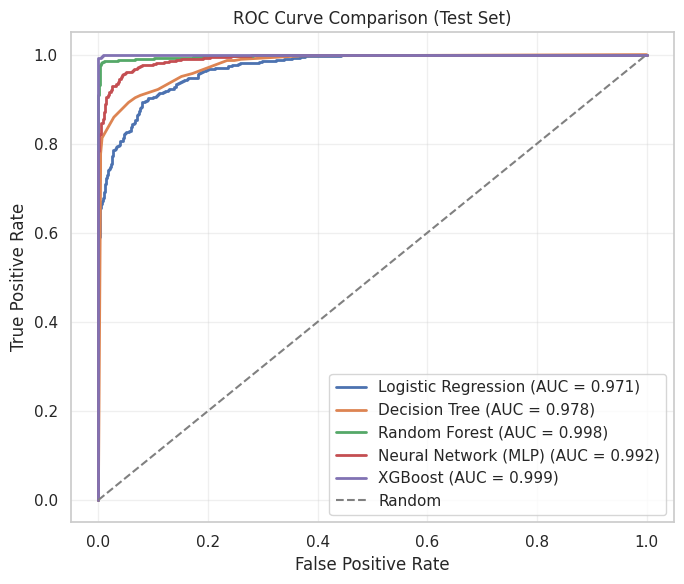

In [31]:
def plot_roc_curve(model, X, y, label):
    # roc curve plot
    proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, proba)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc_val:.3f})")

plt.figure(figsize=(7, 6))

# model roc curves
plot_roc_curve(final_baseline_model, X_test_final, y_test, "Logistic Regression")
plot_roc_curve(dt_model, X_test_final, y_test, "Decision Tree")
plot_roc_curve(rf_model, X_test_final, y_test, "Random Forest")
plot_roc_curve(mlp_model, X_test_final, y_test, "Neural Network (MLP)")

# boosting model roc curve
if "xgb_model" in globals():
    plot_roc_curve(xgb_model, X_test_final, y_test, "XGBoost")
elif "hgb_model" in globals():
    plot_roc_curve(hgb_model, X_test_final, y_test, "HistGradientBoosting")

# random baseline
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Test Set)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



*   While logistic regression provided an interpretable baseline, tree-based ensemble models substantially improved predictive performance.
*   Among them, XGBoost consistently outperformed alternatives in both ROC–AUC and threshold-based metrics, leading to its selection as the final model.

## **7.2 Variable Importance Plot**

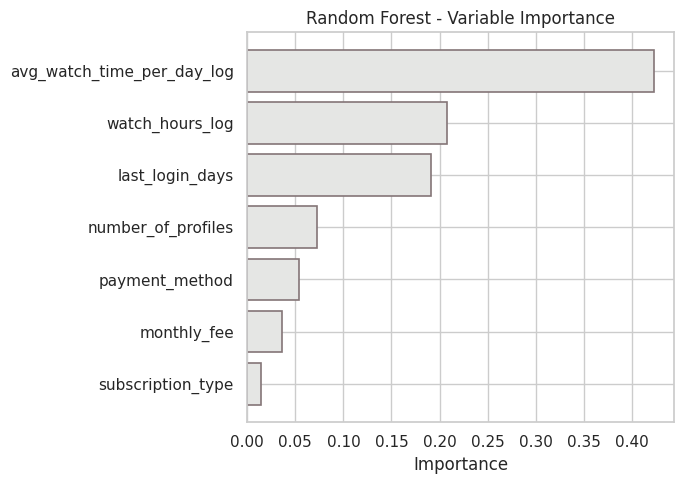

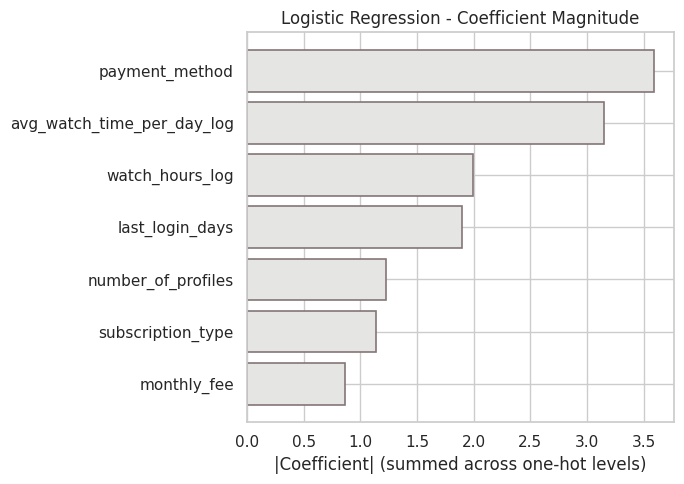

Spearman rank correlation (RF vs LR): 0.607


,orig_feature,importance,abs_coef,rank_rf,rank_lr
0,avg_watch_time_per_day_log,0.422620,3.153611,1.0,2.0
1,watch_hours_log,0.207941,1.991022,2.0,3.0
2,last_login_days,0.191566,1.899547,3.0,4.0
3,number_of_profiles,0.072961,1.225513,4.0,5.0
4,payment_method,0.054359,3.589189,5.0,1.0
5,monthly_fee,0.035806,0.863259,6.0,7.0
6,subscription_type,0.014748,1.137728,7.0,6.0


In [32]:
def get_transformed_feature_names(preprocessor, numeric_features, categorical_features):
    # numeric names
    num_names = list(numeric_features)
    # one-hot names
    ohe = preprocessor.named_transformers_["cat"]
    cat_ohe_names = list(ohe.get_feature_names_out(categorical_features))
    return num_names + cat_ohe_names

def aggregate_importance_to_original(feature_names, importances, numeric_features, categorical_features):
    # importance dataframe
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})

    numeric_df = imp_df[imp_df["feature"].isin(numeric_features)].copy()
    numeric_df["orig_feature"] = numeric_df["feature"]

    cat_df = imp_df[~imp_df["feature"].isin(numeric_features)].copy()

    # map one-hot to original feature
    def map_to_orig(feat):
        for c in categorical_features:
            if feat.startswith(c + "_"):
                return c
        return feat.split("_")[0]

    cat_df["orig_feature"] = cat_df["feature"].apply(map_to_orig)

    # aggregate importance
    agg = pd.concat([numeric_df, cat_df], axis=0) \
            .groupby("orig_feature", as_index=False)["importance"].sum() \
            .sort_values("importance", ascending=False)

    # allowed features
    allowed = set(numeric_features + categorical_features)
    agg = agg[agg["orig_feature"].isin(allowed)]
    return agg.reset_index(drop=True)

def aggregate_coef_to_original(feature_names, coefs, numeric_features, categorical_features):
    # coefficient dataframe
    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()

    numeric_df = coef_df[coef_df["feature"].isin(numeric_features)].copy()
    numeric_df["orig_feature"] = numeric_df["feature"]

    cat_df = coef_df[~coef_df["feature"].isin(numeric_features)].copy()

    # map one-hot to original feature
    def map_to_orig(feat):
        for c in categorical_features:
            if feat.startswith(c + "_"):
                return c
        return feat.split("_")[0]

    cat_df["orig_feature"] = cat_df["feature"].apply(map_to_orig)

    # aggregate coefficients
    agg = pd.concat([numeric_df, cat_df], axis=0) \
            .groupby("orig_feature", as_index=False)["abs_coef"].sum() \
            .sort_values("abs_coef", ascending=False)

    # allowed features
    allowed = set(numeric_features + categorical_features)
    agg = agg[agg["orig_feature"].isin(allowed)]
    return agg.reset_index(drop=True)

# random forest importance
top_n = 10
rf_pre = rf_model.named_steps["preprocessor"]
rf_clf = rf_model.named_steps["classifier"]

rf_feature_names = get_transformed_feature_names(rf_pre, final_numeric_features, final_categorical_features)
rf_importances = rf_clf.feature_importances_
rf_imp_agg = aggregate_importance_to_original(
    rf_feature_names, rf_importances, final_numeric_features, final_categorical_features
)

rf_top = rf_imp_agg.head(top_n).iloc[::-1]
plt.figure(figsize=(7, 5))
plt.barh(
    rf_top["orig_feature"],
    rf_top["importance"],
    color="#E5E6E4",
    edgecolor="#847577",
    linewidth=1.2
)
plt.title("Random Forest - Variable Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# logistic regression coefficients
lr_pre = final_baseline_model.named_steps["preprocessor"]
lr_clf = final_baseline_model.named_steps["classifier"]

lr_feature_names = get_transformed_feature_names(lr_pre, final_numeric_features, final_categorical_features)
lr_coefs = lr_clf.coef_.ravel()
lr_coef_agg = aggregate_coef_to_original(
    lr_feature_names, lr_coefs, final_numeric_features, final_categorical_features
)

lr_top = lr_coef_agg.head(top_n).iloc[::-1]
plt.figure(figsize=(7, 5))
plt.barh(
    lr_top["orig_feature"],
    lr_top["abs_coef"],
    color="#E5E6E4",
    edgecolor="#847577",
    linewidth=1.2
)
plt.title("Logistic Regression - Coefficient Magnitude")
plt.xlabel("|Coefficient| (summed across one-hot levels)")
plt.tight_layout()
plt.show()

# spearman rank correlation
merged = pd.merge(
    rf_imp_agg[["orig_feature", "importance"]],
    lr_coef_agg[["orig_feature", "abs_coef"]],
    on="orig_feature",
    how="inner"
)

merged["rank_rf"] = merged["importance"].rank(ascending=False, method="average")
merged["rank_lr"] = merged["abs_coef"].rank(ascending=False, method="average")

spearman_corr = merged[["rank_rf", "rank_lr"]].corr(method="spearman").iloc[0, 1]
print("Spearman rank correlation (RF vs LR):", round(float(spearman_corr), 3))

merged.sort_values("rank_rf")

*   The top five important features are consistent across Random Forest and Logistic Regression, indicating that the churn drivers are robust and not model-specific.

## **7.3 Final Evaluation of the Selected Model**

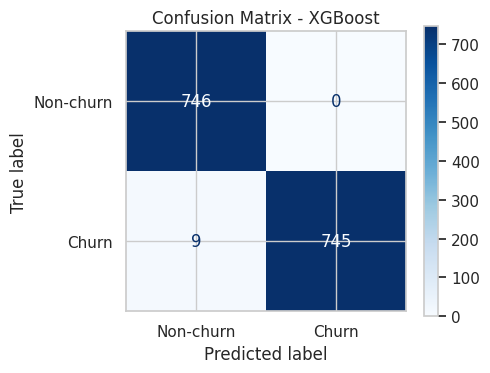

TN=746, FP=0, FN=9, TP=745


In [33]:
def plot_confusion(res, title="Confusion Matrix"):
    # evaluation result dict
    cm = res["confusion_matrix"]

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-churn", "Churn"]
    )

    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    # tn fp fn tp
    tn, fp, fn, tp = cm.ravel()
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# plot available model
if "xgb_res" in globals():
    plot_confusion(xgb_res, "Confusion Matrix - XGBoost")
elif "hgb_res" in globals():
    plot_confusion(hgb_res, "Confusion Matrix - HistGradientBoosting")

*   At the default threshold of 0.5, the final model demonstrates extremely strong performance, with no false positives and only a small number of false negatives.
*   This indicates that customers predicted as churn are highly reliable, while the majority of actual churn cases are successfully identified.